# Live tweet counter: Hawkeye

In this notebook, we will analyze the number of tweets with the hashtag #Hawkeye that are sent every 5 minutes, during the day of the air date of Marvel Studios' Hawkeye season finale.

**NOTES**:
* The season finale of Hawkeye will be available on Disney+ at 9 a.m. CET on Wednesday, December 22. We will start the analysis from the air date.

## Required libraries

In [ ]:
from time import time
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np

## Variables

In [ ]:
BATCH_DURATION = 300
PORT = 9999
hostname = "localhost"
fig_save = "output/hawkeye.jpg"
pd_save = "output/hawkeye.csv"

## Spark and Streaming Context

In [ ]:
sc = SparkContext.getOrCreate()
ssc = StreamingContext(sc, BATCH_DURATION)
lines = ssc.socketTextStream(hostname, PORT)

## RDD Processing

In [ ]:
counter_list = [] 
time_list = []

def process_rdd(time, rdd):
    counter_list.append(rdd.first())
    time_list.append(time)

## Timestamp

In [ ]:
def format_timestamp(x):
    return x.strftime("%Y-%m-%d %H:%M:%S")

In [ ]:
def print_timedelta(date_start):
    print("Start tweet analysis: " + format_timestamp(date_start))
    date_now = dt.datetime.now()
    print("Last update: " + format_timestamp(date_now))
    delta = date_now - date_start
    delta_seconds = delta.seconds
    delta_hours = delta_seconds/3600
    delta_minutes = (delta_seconds/60)%60
    delta_seconds = delta_seconds%60
    if delta.days!=0:
        print("Elapsed time: %d days, %d hours, %d minutes, %d seconds" 
                % (delta.days, delta_hours, delta_minutes, delta_seconds))
    else:
        print("Elapsed time: %d hours, %d minutes, %d seconds" 
                % (delta_hours, delta_minutes, delta_seconds))

## Discretized stream

In [ ]:
lines.count().foreachRDD(process_rdd)

## Start Streaming

Run the script *tweets_stream.py*.

In [ ]:
ssc.start()

print("Starting tweeet analysis...")
start = dt.datetime.now()

Starting tweeet analysis...


## Tweet counter

Start tweet analysis: 2021-12-22 08:56:12
Last update: 2021-12-22 22:59:41
Elapsed time: 14 hours, 3 minutes, 28 seconds


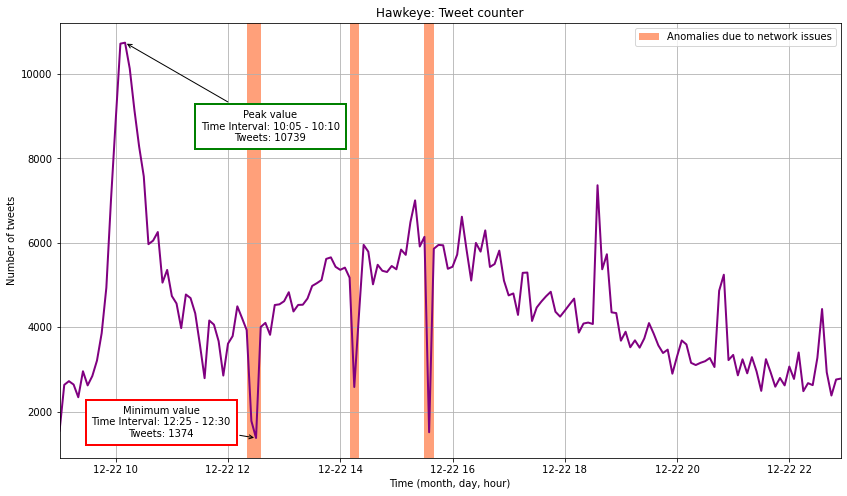

Total tweets: 751852
Average of tweets per batch (5 minutes): 4475


In [ ]:
print_timedelta(start)

# Convert to Pandas dataframe and save locally as a csv.
counter_pd = pd.DataFrame({"Time": time_list,"Count": counter_list})
counter_pd.to_csv(pd_save)

# Plot
x = time_list
y = counter_list
fig, ax = plt.subplots()
ax.plot(x,y, color='purple', lw=2)
plt.rcParams['figure.figsize'] = [14,8]
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.05
plt.title("Hawkeye: Tweet counter")
plt.xlabel("Time (month, day, hour)")
plt.ylabel("Number of tweets")
plt.grid()

# Max value
ymax = max(y)
max_index = y.index(ymax)
xmax = x[max_index]
text_max = "Peak value\nTime Interval: {prev_max} - {xmax}\nTweets: {ymax}" \
                .format(prev_max=x[max_index-1].strftime("%H:%M"),
                        xmax=xmax.strftime("%H:%M"), 
                        ymax=ymax)
bbox_props = dict(boxstyle="square,pad=0.6", fc="w", ec="green", lw=2)
arrowprops=dict(arrowstyle="->",connectionstyle="arc3, rad=0")
kw = dict(xycoords='data',textcoords="axes fraction",
          arrowprops=arrowprops, bbox=bbox_props, ha="center", va="top")
ax.annotate(text_max, xy=(xmax, ymax), xytext=(0.27,0.80), **kw)

# Min value
ymin = min(y)
min_index = y.index(ymin)
xmin = x[min_index]
text_min = "Minimum value\nTime Interval: {prev_min} - {xmin}\nTweets: {ymin}" \
                .format(prev_min=x[min_index-1].strftime("%H:%M"),
                        xmin=xmin.strftime("%H:%M"), 
                        ymin=ymin)
bbox_props = dict(boxstyle="square,pad=0.6", fc="w", ec="red", lw=2)
arrowprops=dict(arrowstyle="->",connectionstyle="arc3, rad=0")
kw = dict(xycoords='data',textcoords="axes fraction",
          arrowprops=arrowprops, bbox=bbox_props, ha="center", va="top")
ax.annotate(text_min, xy=(xmin, ymin), xytext=(0.13,0.12), **kw)

# Anomalies
ax.axvspan(dt.datetime.strptime("2021/12/22 12:20", "%Y/%m/%d %H:%M"), 
           dt.datetime.strptime("2021/12/22 12:35", "%Y/%m/%d %H:%M"), 
           facecolor='lightsalmon', label="Anomalies due to network issues")
ax.axvspan(dt.datetime.strptime("2021/12/22 14:10", "%Y/%m/%d %H:%M"), 
           dt.datetime.strptime("2021/12/22 14:20", "%Y/%m/%d %H:%M"), 
           facecolor='lightsalmon', label="_Anomalies due to network issues")
ax.axvspan(dt.datetime.strptime("2021/12/22 15:30", "%Y/%m/%d %H:%M"), 
           dt.datetime.strptime("2021/12/22 15:40", "%Y/%m/%d %H:%M"), 
           facecolor='lightsalmon', label="_Anomalies due to network issues")

# Legend, save and show
plt.legend()
plt.savefig(fig_save)
plt.show()

# Total tweets and average
counter_np = np.array(counter_list)
print("Total tweets: %d" % sum(counter_list))
print("Average of tweets per batch (5 minutes): %d" % np.mean(counter_np))